# MadMiner particle physics tutorial

# Part 4b: The Fisher information

Johann Brehmer, Felix Kling, Irina Espejo, and Kyle Cranmer 2018-2019

## 0. Preparations

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import six
import logging
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline


In [2]:
# MadMiner output
logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.INFO
)

# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "madminer" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)

In [3]:
from madminer import FisherInformation, plot_fisher_information_contours_2d

11:21 madminer             INFO    
11:21 madminer             INFO    ------------------------------------------------------------------------
11:21 madminer             INFO    |                                                                      |
11:21 madminer             INFO    |  MadMiner v0.7.0                                                     |
11:21 madminer             INFO    |                                                                      |
11:21 madminer             INFO    |         Johann Brehmer, Felix Kling, Irina Espejo, and Kyle Cranmer  |
11:21 madminer             INFO    |                                                                      |
11:21 madminer             INFO    ------------------------------------------------------------------------
11:21 madminer             INFO    


## 1. Calculating the Fisher information from a SALLY model

We can use SALLY estimators (see part 3b of this tutorial) not just to define optimal observables, but also to calculate the (expected) Fisher information in a process. In `madminer.fisherinformation` we provide the `FisherInformation` class that makes this more convenient.

In [3]:
fisher = FisherInformation('data/lhe_data_shuffled.h5')
# fisher = FisherInformation('data/delphes_data_shuffled.h5')

23:10 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
23:10 madminer.analysis    INFO    Found 2 parameters
23:10 madminer.analysis    INFO    Did not find nuisance parameters
23:10 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
23:10 madminer.analysis    INFO    Found 3 observables
23:10 madminer.analysis    INFO    Found 539913 events
23:10 madminer.analysis    INFO      499913 signal events sampled from benchmark sm
23:10 madminer.analysis    INFO      10000 signal events sampled from benchmark w
23:10 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
23:10 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
23:10 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
23:10 madminer.analysis    INFO    Found morphing setup with 6 components
23:10 madminer.analysis    INFO    Did not find nuisance morphing setup


This class provides different functions:
- `rate_information()` calculates the Fisher information in total rates,
- `histo_information()` calculates the Fisher information in 1D histograms,
- `histo_information_2d()` calculates the Fisher information in 2D histograms,
- `full_information()` calculates the full detector-level Fisher information using a SALLY estimator, and
- `truth_information()` calculates the truth-level Fisher information.

Here we use the SALLY approach:

In [4]:
info_sally, _ = fisher.full_information(
    theta=[0.,0.],
    model_file='models/sally',
    luminosity=300.*1000.,
)

print('Fisher information after 300 ifb:\n{}'.format(info_sally))

23:10 madminer.ml          INFO    Loading model from models/sally
23:10 madminer.fisherinfor INFO    Found 2 parameters in Score Estimator model, matching 2 physical parameters in MadMiner file
23:10 madminer.fisherinfor INFO    Evaluating rate Fisher information
23:11 madminer.fisherinfor INFO    Evaluating kinematic Fisher information on batch 1 / 2
23:11 madminer.ml          INFO    Loading evaluation data
23:11 madminer.ml          INFO    Starting score evaluation
23:11 madminer.ml          INFO    Calculating Fisher information
23:11 madminer.fisherinfor INFO    Evaluating kinematic Fisher information on batch 2 / 2
23:11 madminer.ml          INFO    Loading evaluation data
23:11 madminer.ml          INFO    Starting score evaluation
23:11 madminer.ml          INFO    Calculating Fisher information


Fisher information after 300 ifb:
[[171.87438526  -1.08162341]
 [ -1.08162341 109.88667781]]


For comparison, we can calculate the Fisher information in the histogram of observables:

In [5]:
info_histo_1d, cov_histo_1d = fisher.histo_information(
    theta=[0.,0.],
    luminosity=300.*1000.,
    observable="pt_j1",
    bins=[30.,100.,200.,400.],
    histrange=[30.,400.],
)

print('Histogram Fisher information after 300 ifb:\n{}'.format(info_histo_1d))

23:12 madminer.fisherinfor INFO    Bins with largest statistical uncertainties on rates:
23:12 madminer.fisherinfor INFO      Bin 1: (0.01679 +/- 0.00060) fb (4 %)
23:12 madminer.fisherinfor INFO      Bin 5: (0.00622 +/- 0.00011) fb (2 %)
23:12 madminer.fisherinfor INFO      Bin 4: (0.07247 +/- 0.00040) fb (1 %)
23:12 madminer.fisherinfor INFO      Bin 2: (0.60419 +/- 0.00264) fb (0 %)
23:12 madminer.fisherinfor INFO      Bin 3: (0.34005 +/- 0.00117) fb (0 %)


Histogram Fisher information after 300 ifb:
[[ 1.20370338e+02 -5.77619073e-01]
 [-5.77619073e-01  4.95972924e-03]]


We can do the same thing in 2D:

In [6]:
info_histo_2d, cov_histo_2d = fisher.histo_information_2d(
    theta=[0.,0.],
    luminosity=300.*1000.,
    observable1="pt_j1",
    bins1=[30.,100.,200.,400.],
    histrange1=[30.,400.],
    observable2="delta_phi_jj",
    bins2=5,
    histrange2=[0,6.2],
)

print('Histogram Fisher information after 300 ifb:\n{}'.format(info_histo_2d))

23:13 madminer.fisherinfor INFO    Bins with largest statistical uncertainties on rates:
23:13 madminer.fisherinfor INFO      Bin (1, 3): (0.00413 +/- 0.00049) fb (12 %)
23:13 madminer.fisherinfor INFO      Bin (1, 2): (0.00315 +/- 0.00023) fb (7 %)
23:13 madminer.fisherinfor INFO      Bin (5, 2): (0.00089 +/- 0.00004) fb (5 %)
23:13 madminer.fisherinfor INFO      Bin (5, 4): (0.00102 +/- 0.00004) fb (4 %)
23:13 madminer.fisherinfor INFO      Bin (5, 3): (0.00123 +/- 0.00005) fb (4 %)


Histogram Fisher information after 300 ifb:
[[132.0915244    1.71938164]
 [  1.71938164  89.00978151]]


/Users/felixkling/Documents/GitHub/madminer/madminer/fisherinformation.py:1184: RuntimeWarning: divide by zero encountered in true_divide
  inv_sigma = sanitize_array(1.0 / sigma)  # Shape (n_events,)


## 2. Calculating the Fisher information from a SALLY model

We can also calculate the Fisher Information using an ALICES model

In [7]:
info_alices, _ = fisher.full_information(
    theta=[0.,0.],
    model_file='models/alices',
    luminosity=300.*1000.,
)

print('Fisher information using ALICES after 300 ifb:\n{}'.format(info_alices))

23:13 madminer.ml          INFO    Loading model from models/alices
23:13 madminer.fisherinfor INFO    Found 2 parameters in Parameterized Ratio Estimator model, matching 2 physical parameters in MadMiner file
23:14 madminer.fisherinfor INFO    Evaluating rate Fisher information
23:14 madminer.fisherinfor INFO    Evaluating kinematic Fisher information on batch 1 / 2
23:14 madminer.ml          INFO    Loading evaluation data
23:14 madminer.ml          INFO    Loading evaluation data
23:14 madminer.ml          INFO    Starting ratio evaluation
23:14 madminer.ml          INFO    Evaluation done
23:14 madminer.ml          INFO    Calculating Fisher information
23:14 madminer.fisherinfor INFO    Evaluating kinematic Fisher information on batch 2 / 2
23:14 madminer.ml          INFO    Loading evaluation data
23:14 madminer.ml          INFO    Loading evaluation data
23:14 madminer.ml          INFO    Starting ratio evaluation
23:14 madminer.ml          INFO    Evaluation done
23:14 madminer

Fisher information using ALICES after 300 ifb:
[[122.3049051   -3.46912463]
 [ -3.46912463  92.31383615]]


## 3. Plot Fisher distances

We also provide a convenience function to plot contours of constant Fisher distance `d^2(theta, theta_ref) = I_ij(theta_ref) * (theta-theta_ref)_i * (theta-theta_ref)_j`:

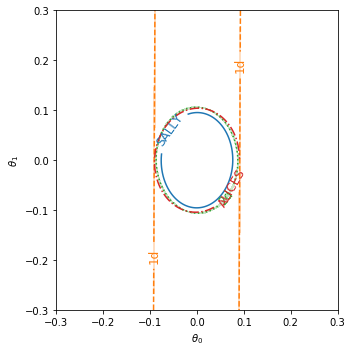

In [8]:
_ = plot_fisher_information_contours_2d(
    [info_sally, info_histo_1d, info_histo_2d,info_alices],
    [None, cov_histo_1d, cov_histo_2d,None],
    inline_labels=["SALLY", "1d", "2d","ALICES"],
    xrange=(-0.3,0.3),
    yrange=(-0.3,0.3)
)